## RFM Analysis<a id="Top"></a>

## Table of Contents

1. [Load Needed Packages](#1)<br>
2. [Get Data](#2)<br>
    2.1 [Read in the Data from csv](#2.1)<br>
    2.2 [Clean Data](#2.2)<br>
3. [Calculate Metrics](#3)<br>
4. [Set Up Tiers](#4)<br>
5. [Segmentation Examples](#5)<br>
    5.1 [Soulmate](#5.1)<br>
    5.2 [Lover](#5.2)<br>
    5.3 [Potential Lover](#5.3)<br>
    5.4 [New Passion](#5.4)<br>
    5.5 [About to Dump You](#5.5)<br>
    5.6 [Ex Lover](#5.6)<br>
    5.7 [Departed](#5.7)<br>

---
## 1. Load Needed Packages<a id=1></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # Never print matching warnings

##### [Back to Top](#Top)

---
## 2. Get Data<a id=2></a>

### 2.1 Read in the Data from csv<a id=2.1></a>
Data source: https://www.kaggle.com/datasets/kyanyoga/sample-sales-data

In [2]:
raw = pd.read_csv("data/sales_data_sample.csv",encoding="unicode_escape")
print('There are ' +str(len(raw)) + ' observations')

There are 2823 observations


In [3]:
raw.head(2)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.0,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.9,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small


In [4]:
# Extract useful metrics for RFM analysis
df = raw[['CUSTOMERNAME', 'ORDERNUMBER', 'ORDERDATE', 'SALES']]

df.head()

,CUSTOMERNAME,ORDERNUMBER,ORDERDATE,SALES
0,Land of Toys Inc.,10107,2/24/2003 0:00,2871.00
1,Reims Collectables,10121,5/7/2003 0:00,2765.90
2,Lyon Souveniers,10134,7/1/2003 0:00,3884.34
3,Toys4GrownUps.com,10145,8/25/2003 0:00,3746.70
4,Corporate Gift Ideas Co.,10159,10/10/2003 0:00,5205.27


### 2.2 Clean Data<a id=2.2></a>

In [5]:
# Check the structure or type of each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CUSTOMERNAME  2823 non-null   object 
 1   ORDERNUMBER   2823 non-null   int64  
 2   ORDERDATE     2823 non-null   object 
 3   SALES         2823 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 88.3+ KB


In [6]:
# Remove rows with null values
## As there are no nulls in this dataset, this function won't affect it
## Keeping the code here makes it applicable to different datasets
df.dropna(inplace=True)
print('There are ' +str(len(df)) + ' observations')

There are 2823 observations


In [7]:
# Remove duplicate rows
df.drop_duplicates(inplace=True, ignore_index=True)
print('There are ' +str(len(df)) + ' observations')

There are 2823 observations


In [8]:
# Convert ORDERDATE to datetime data type
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [9]:
df.head()

,CUSTOMERNAME,ORDERNUMBER,ORDERDATE,SALES
0,Land of Toys Inc.,10107,2003-02-24,2871.00
1,Reims Collectables,10121,2003-05-07,2765.90
2,Lyon Souveniers,10134,2003-07-01,3884.34
3,Toys4GrownUps.com,10145,2003-08-25,3746.70
4,Corporate Gift Ideas Co.,10159,2003-10-10,5205.27


##### [Back to Top](#Top)

---
## 3. Calculate Metrics<a id=3></a>

In [10]:
# Compute the most recent order time for subsequent calculation of Recency
latest_order_date = df['ORDERDATE'].max()
latest_order_date

Timestamp('2005-05-31 00:00:00')

In [11]:
rfm_df = df.groupby('CUSTOMERNAME').agg({'ORDERDATE': 'max', # When is the last order date for each customer?
                                                                             'ORDERNUMBER': pd.Series.nunique, # How many times has each customer purchased?
                                                                             'SALES': 'sum' # How much has each customer spent?
                                                                            }).reset_index()

# Rename the new RFM table
rfm_df.rename(columns={'ORDERDATE': 'LASTESTDATE', 
                                           'ORDERNUMBER': 'FREQUENCY',
                                           'SALES': 'MONETARY'}, inplace=True)

rfm_df.head(2)

,CUSTOMERNAME,LASTESTDATE,FREQUENCY,MONETARY
0,"AV Stores, Co.",2004-11-17,3,157807.81
1,Alpha Cognac,2005-03-28,3,70488.44


In [12]:
# Calculate Recency value
rfm_df['RECENCY'] = (latest_order_date - rfm_df['LASTESTDATE'])/np.timedelta64(1, 'D')
# Delete LASTESTDATE column
rfm_df.drop('LASTESTDATE', axis=1, inplace=True)
# Rearrange the RECENCY column in front of the FREQUENCY column
rfm_df.insert(1, 'RECENCY', rfm_df.pop('RECENCY'))

In [13]:
rfm_df.head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY
0,"AV Stores, Co.",195.0,3,157807.81
1,Alpha Cognac,64.0,3,70488.44
2,Amica Models & Co.,264.0,2,94117.26
3,"Anna's Decorations, Ltd",83.0,4,153996.13
4,Atelier graphique,187.0,3,24179.96


##### [Back to Top](#Top)

---
## 4. Set Up Tiers<a id=4></a>

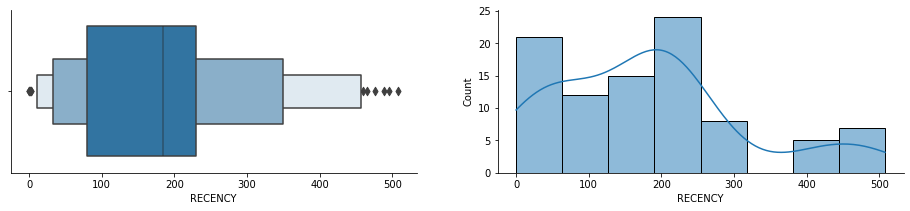

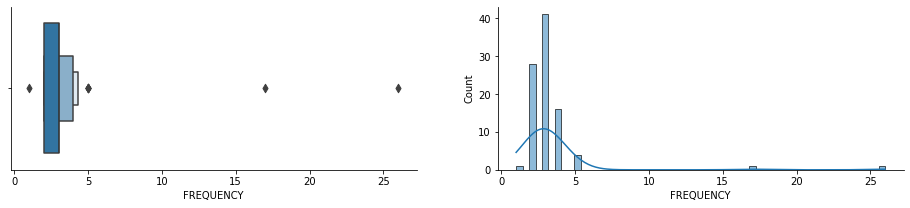

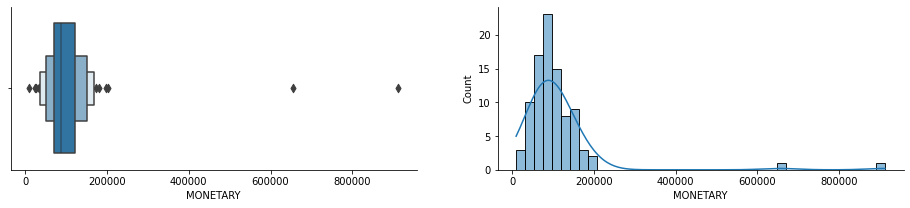

In [14]:
# Visualize RFM metrics
for col in ['RECENCY','FREQUENCY','MONETARY']:
    f, axs = plt.subplots(ncols=2, figsize=(16, 3))
    sns.despine(f)
    
    sns.boxenplot(x=rfm_df[col],ax=axs[0])
    sns.histplot(x=rfm_df[col], kde=True, ax=axs[1])
    
    plt.show()

In [15]:
# The RFM tiers will be determined by quartiles, so we should first view the threshold for each Quartile.
rfm_df.quantile(q=[0.25,0.5,0.75])

,RECENCY,FREQUENCY,MONETARY
0.25,80.25,2.0,70129.4325
0.50,185.00,3.0,86522.6100
0.75,229.25,3.0,120575.8750


<center><h3>-- Description of Tiers --</h3></center>

<table>
    <tr>
        <th><center>Tier</center></th>
        <th><center>Recency</center></th>
        <th><center>Frequency</center></th>
        <th><center>Monetary</center></th>
    </tr>
    <tr>
        <td><center><strong>Tier 1</strong></center></td>
        <td><center>Most Recent</center></td>
        <td><center>Most Transaction</center></td>
        <td><center>Highest Spend</center></td>
    </tr>
    <tr>
        <td><center><strong>Tier 2</strong></center></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td><center><strong>Tier 3</strong></center></td>
        <td></td>
        <td><center>Fewest Transaction</center></td>
        <td></td>
    </tr>
    <tr>
        <td><center><strong>Tier 4</strong></center></td>
        <td><center>Least Recent</center></td>
        <td><center>-</center></td>
        <td><center>Lowest Spend</center></td>
    </tr>
</table>

In [16]:
# Recency Tiers
rfm_df['R_TIER']= pd.qcut(rfm_df['RECENCY'], q = 4, labels = [1,2,3,4])

# Frequency Tiers
## Because 2nd and 3rd quartile of FREQUENCY are both 3
## But all records with the same value should stay in the same quantile
## So drop one quantile causing only 3 tiers of FREQUENCY
rfm_df['F_TIER']= pd.qcut(rfm_df['FREQUENCY'], q = 4, labels = [3,2,1], duplicates = 'drop')

# Monetary Tiers
rfm_df['M_TIER']= pd.qcut(rfm_df['MONETARY'], q = 4, labels = [4,3,2,1])

rfm_df.head(2)

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER
0,"AV Stores, Co.",195.0,3,157807.81,3,2,1
1,Alpha Cognac,64.0,3,70488.44,1,2,3


In [17]:
# Check the data type of each variable
rfm_df.dtypes

CUSTOMERNAME      object
RECENCY          float64
FREQUENCY          int64
MONETARY         float64
R_TIER          category
F_TIER          category
M_TIER          category
dtype: object

In [18]:
# Convert category data to string type
rfm_df[['R_TIER','F_TIER','M_TIER']] = rfm_df[['R_TIER','F_TIER','M_TIER']].astype(str)

# Concatenate the R, F, and M tiers to get a RFM score
rfm_df['RFM'] = rfm_df['R_TIER'] + rfm_df['F_TIER'] + rfm_df['M_TIER']

rfm_df.head(2)

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
0,"AV Stores, Co.",195.0,3,157807.81,3,2,1,321
1,Alpha Cognac,64.0,3,70488.44,1,2,3,123


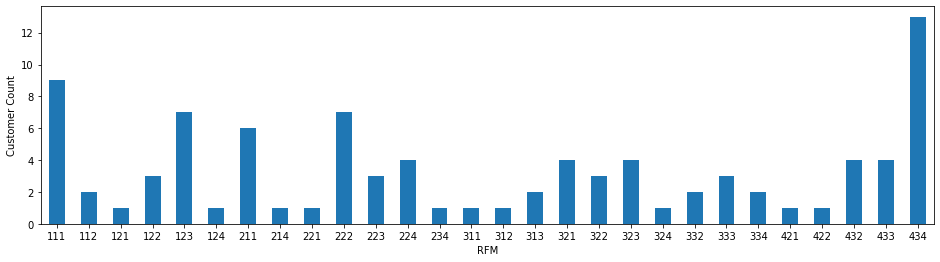

In [19]:
# Visualize customer numbers by RFM score
plt.figure(figsize=(16,4))

rfm_df['RFM'].value_counts().sort_index().plot(kind='bar')

# Format plots
plt.xlabel('RFM')
plt.ylabel('Customer Count')
plt.xticks(rotation = 0)

plt.show()

##### [Back to Top](#Top)

---
## 5. Segmentation Examples<a id=5></a>

In [20]:
# Convert string data to integers
rfm_df[['R_TIER','F_TIER','M_TIER','RFM']] = rfm_df[['R_TIER','F_TIER','M_TIER','RFM']].astype(int)

### 5.1 Soulmate<a id=5.1></a>

**RFM:** 111

**Customer Segment:** They are the most valuable customers who purchased the most recently, buy the most frequently, and spend the highest money.

**Marketing Strategy:** The priority should be paid to this group of customers and the satisfaction of these customers should be improved in order to increase customer retention. VIP services and personalized services can be provided to enhance the user experience.

In [21]:
rfm_df[rfm_df['RFM']==111].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
33,Euro Shopping Channel,0.0,26,912294.11,1,1,1,111
55,Mini Gifts Distributors Ltd.,2.0,17,654858.06,1,1,1,111
44,La Rochelle Gifts,0.0,4,180124.90,1,1,1,111
81,The Sharp Gifts Warehouse,39.0,4,160010.27,1,1,1,111
75,Souveniers And Things Co.,2.0,4,151570.98,1,1,1,111


### 5.2 Lover<a id=5.2></a>

**RFM:** 222

**Customer Segment:** The amount and frequency of their purchases are considerable, and it has not been too long since their last purchase. Lover customers have a high probability of becoming Soulmates.

**Marketing Strategy:** Survey these customers to learn about their experiences and opinions.

In [22]:
rfm_df[rfm_df['RFM']==222].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
77,Suominen Souveniers,145.0,3,113961.15,2,2,2,222
84,"Toys of Finland, Co.",111.0,3,111250.38,2,2,2,222
54,Mini Creations Ltd.,144.0,3,108951.13,2,2,2,222
85,Toys4GrownUps.com,139.0,3,104561.96,2,2,2,222
63,"Oulu Toy Supplies, Inc.",120.0,3,104370.38,2,2,2,222


### 5.3 Potential Lover<a id=5.3></a>

**RFM:** 223

**Customer Segment:** Potential Lover customers spend less than Lover customers. These customers recently purchased, whose total transactions are nice, but the cumulative consumption amount is low, which means their AOV is low.

**Marketing Strategy:** Upsell more appealing services/products to this group of customers. Offer them discounts in order to entice them.

In [23]:
rfm_df[rfm_df['RFM']==223].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
74,Signal Gift Stores,183.0,3,82751.08,2,2,3,223
22,Collectables For Less Inc.,131.0,3,81577.98,2,2,3,223
47,Marseille Mini Autos,145.0,3,74936.14,2,2,3,223


### 5.4 New Passion<a id=5.4></a>

**RFM:** 13X, 23X

**Customer Segment:** Recently purchased goods, but with the fewest purchases, are more likely to be new customers. These individuals are in a state of curiosity about a service or product, or are seeking value.

**Marketing Strategy:** Send a welcome email featuring the brand's introduction, or offer a free trial to increase customer interest and brand awareness.

In [24]:
rfm_df[(rfm_df['R_TIER']<=2)&(rfm_df['F_TIER']==3)].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
14,Boards & Toys Co.,112.0,2,9129.35,2,3,4,234


### 5.5 About to Dump You<a id=5.5></a>

**RFM:** 334

**Customer Segment:** Their reency, frequency, and monetary are all poor. It may be that they are awaiting Wow, or may have suffered a bad consumer experience.

**Marketing Strategy:** Up-sell or cross-sell to these customers in order to win them back.

In [25]:
rfm_df[rfm_df['RFM']==334].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
18,"Classic Gift Ideas, Inc",229.0,2,67506.97,3,3,4,334
50,Microscale Inc.,209.0,2,33144.93,3,3,4,334


### 5.6 Ex Lover<a id=5.6></a>

**RFM:** 411

**Customer Segment:** They spent the most money, placed the most orders, but did not place an order for a long time. These are former top-notch clients.

**Marketing Strategy:** Deliver a customized reactivation campaign, such as discounts, to reconnect with these customers. Make them aware of new services/products.

In [26]:
rfm_df[rfm_df['RFM']==411].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM


### 5.7 Departed<a id=5.7></a>

**RFM:** 43X, 44X (Not available for this dataset)

**Customer Segment:** These are lapsed customers whose three indicators are all unacceptable.

**Marketing Strategy:** Take actions, such as issuing coupons and pushing. Consider reducing the marketing and service budget for such customers, and strive not to carry out too many retention activities since the retention cost is high.

In [27]:
rfm_df[(rfm_df['R_TIER']==4)&(rfm_df['F_TIER']>=3)].sort_values(['MONETARY'], ascending=False).head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY,R_TIER,F_TIER,M_TIER,RFM
87,"Vida Sport, Ltd",274.0,2,117713.56,4,3,2,432
48,Marta's Replicas Co.,230.0,2,103080.38,4,3,2,432
2,Amica Models & Co.,264.0,2,94117.26,4,3,2,432
21,Collectable Mini Designs Co.,460.0,2,87489.23,4,3,2,432
78,Super Scale Inc.,392.0,2,79472.07,4,3,3,433


##### [Back to Top](#Top)